<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/03_Advance/GAN/LSGAN/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import random
from tqdm import tqdm

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader 

from torchvision import datasets
from torchvision import transforms

from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set randomness
seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set hyperparameter
epochs= 10
batch_size= 256

In [2]:
# MNIST dataset
mnist_train = datasets.MNIST(root='../../../data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
print("Downloading Train Data Done ! ")

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)

In [3]:
# Defining Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bnorm1 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, 512)
        self.bnorm2 = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512, 784)
        
    def forward(self, X):
        X = F.leaky_relu(self.bnorm1(self.linear1(X)), negative_slope=0.03)
        X = F.leaky_relu(self.bnorm2(self.linear2(X)), negative_slope=0.03)
        X = torch.sigmoid(self.linear3(X))
        return X
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 1)
    
    def forward(self, X):
        X = F.leaky_relu(self.linear1(X), negative_slope=0.03)
        X = F.leaky_relu(self.linear2(X), negative_slope=0.03)
        X = torch.sigmoid(self.linear3(X))
        return X

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.MSELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

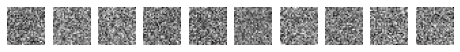

In [4]:
# Helper Function
def plot_generator(G, num=10):
    z = torch.randn(num, 100).to(device)
    
    generated = G.forward(z).cpu().detach()
    plt.figure(figsize=(8, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(generated[i].view(28, 28), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()

plot_generator(G)

[1/10]: 100%|██████████| 235/235 [00:04<00:00, 57.73it/s, D loss=0.009, G loss=0.959]


Epoch : 1, D Loss : 0.167, G Loss : 0.761


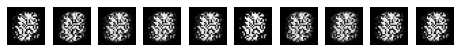

[2/10]: 100%|██████████| 235/235 [00:03<00:00, 61.59it/s, D loss=0.039, G loss=0.878]


Epoch : 2, D Loss : 0.071, G Loss : 0.904


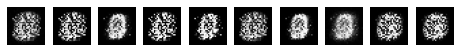

[3/10]: 100%|██████████| 235/235 [00:03<00:00, 62.78it/s, D loss=0.055, G loss=0.885]


Epoch : 3, D Loss : 0.025, G Loss : 0.902


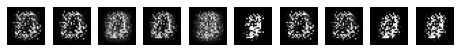

[4/10]: 100%|██████████| 235/235 [00:03<00:00, 59.09it/s, D loss=0.053, G loss=0.914]


Epoch : 4, D Loss : 0.024, G Loss : 0.931


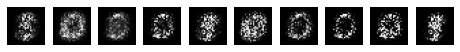

[5/10]: 100%|██████████| 235/235 [00:03<00:00, 59.77it/s, D loss=0.045, G loss=0.883]


Epoch : 5, D Loss : 0.043, G Loss : 0.885


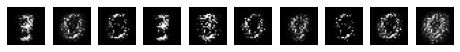

[6/10]: 100%|██████████| 235/235 [00:04<00:00, 58.10it/s, D loss=0.010, G loss=0.917]


Epoch : 6, D Loss : 0.040, G Loss : 0.902


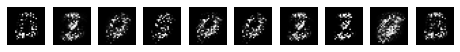

[7/10]: 100%|██████████| 235/235 [00:03<00:00, 60.53it/s, D loss=0.014, G loss=0.937]


Epoch : 7, D Loss : 0.019, G Loss : 0.928


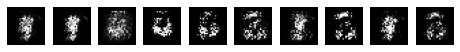

[8/10]: 100%|██████████| 235/235 [00:03<00:00, 71.89it/s, D loss=0.070, G loss=0.876]


Epoch : 8, D Loss : 0.025, G Loss : 0.919


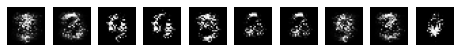

[9/10]: 100%|██████████| 235/235 [00:03<00:00, 60.57it/s, D loss=0.043, G loss=0.884]


Epoch : 9, D Loss : 0.021, G Loss : 0.934


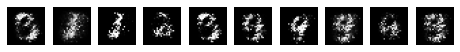

[10/10]: 100%|██████████| 235/235 [00:03<00:00, 64.51it/s, D loss=0.027, G loss=0.957]


Epoch : 10, D Loss : 0.025, G Loss : 0.939


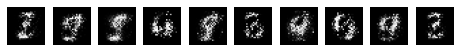

Training Done !


In [5]:
# Training loop
for epoch in range(epochs):
    G.train()
    D.train()
    avg_g_loss = 0
    avg_d_loss = 0
    
    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        for i, (batch_img, _) in enumerate(train_loader):
            
            tmp_batch_siae = batch_img.shape[0]

            X = batch_img.view(tmp_batch_siae, -1).to(device)
        
            real_lab = torch.ones(tmp_batch_siae, 1).to(device)
            
            fake_lab = torch.zeros(tmp_batch_siae, 1).to(device)

            # Training Discriminator
            D_pred = D.forward(X)
            d_loss_real = criterion(D_pred, real_lab)
            real_score = D_pred
            
            z = torch.randn(tmp_batch_siae, 100).to(device)
            
            fake_images = G.forward(z)
            G_pred = D.forward(fake_images)
            d_loss_fake = criterion(G_pred, fake_lab)
            fake_score = G_pred
            
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # Training Generator
            z = torch.randn(tmp_batch_siae, 100).to(device)
            fake_images = G.forward(z)
            G_pred = D.forward(fake_images)
            g_loss = criterion(G_pred, real_lab)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            avg_g_loss += g_loss.item()
            avg_d_loss += d_loss.item()

            
            t.set_postfix({
                            "D loss": f"{d_loss.item():05.3f}", 
                            "G loss": f"{g_loss.item():05.3f}"
                            })
            t.update()

            
    print(f"Epoch : {epoch+1}, D Loss : {avg_d_loss/len(train_loader):.3f}, G Loss : {avg_g_loss/len(train_loader):.3f}")
    plot_generator(G)
print("Training Done !")

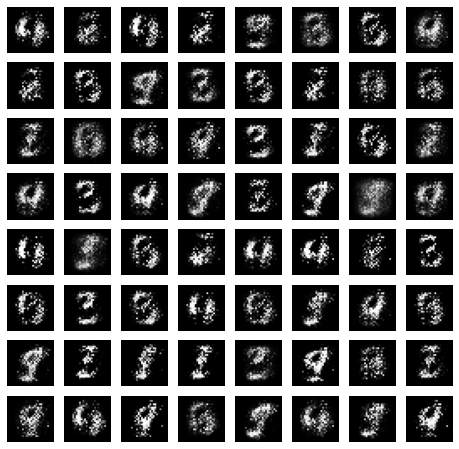

In [6]:
# Sample
num_sample = 64
z = torch.randn(num_sample, 100).to(device)

generated = G.forward(z).cpu().detach()
plt.figure(figsize=(8, 8))
for i in range(num_sample):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated[i].view(28, 28), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()